## Week 5 Lab exercises

In this week we will practise linear algebra using numpy and sympy, and look at the solution of linear ODEs with implicit methods.

In [1]:
# first we import the libraries we need
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# The following lines makes the plots appear inline in the notebook
%matplotlib inline

### ACTIVITY 1: 

I have written a class below for integrating linear equations that implements the (explicit) forward Euler method using matrix methods. Update it to include the (implicit) backwards Euler method. Be sure to add in asserts to sense check what the class is doing.

The class is applied to the system we saw in the lectures:

$\dot x = 998 x + 1998y \quad x(0) = 1$

$\dot y = -999 x - 1999y \quad y(0) = 0$

which can also be written as

$\frac{d}{dt}\begin{bmatrix}
x \\
y
\end{bmatrix} = \begin{bmatrix}
998 & 1998\\
-999 & -1999
\end{bmatrix} \begin{bmatrix}
x \\
y
\end{bmatrix}$

Determine:

1. What is the maximum step size we can take while still keeping the Forward Euler method _stable_?
2. Is this consistent with the bounds we saw in the lecture? 
3. What step size do we need to take in order to keep the Backward Euler method _stable_?
4. Is this consistent with the bounds we saw in the lecture?
5. What step size do we need to take in order to render the Backward Euler method _accurate_?

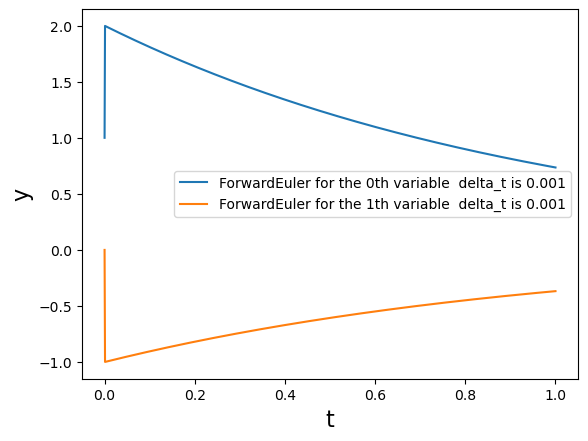

In [3]:
# ExplicitLinearIntegrator class

class ExplicitLinearIntegrator :

    """
    Contains explicit methods to integrate ODEs
    
    attributes: the function to calculate the gradient dydt, max_time, 
                N_time_steps, method
                
    methods: calculate_solution, plot_solution
    
    """
    integration_methods = ["ForwardEuler", "BackwardEuler"]
    
    # constructor function
    def __init__(self, a_C_matrix, max_time=0, N_time_steps=0, method = "ForwardEuler"):
        
        self.C_matrix = a_C_matrix # Note that we are passing in a function, this is ok in python
        self.method = method
        assert self.method in self.integration_methods, 'chosen integration method not implemented'
        
        # Make these private - restrict getting and setting as below
        self._dimension = np.size(self.C_matrix, 0)
        self._max_time = max_time
        self._N_time_steps = N_time_steps
        
        # Derived from the values above
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1, self._dimension])

    # Enables the user to get the y solution
    @property
    def y_solution(self):
        return self._y_solution

    # Enables the user to get the t solution
    @property
    def t_solution(self):
        return self._t_solution
    
    @property
    def max_time(self):
        return self._max_time

    @property
    def N_time_steps(self):
        return self._N_time_steps
    
    # Enables the user to reset the max time
    @max_time.setter
    def max_time(self, value):
        self._max_time = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1,self._dimension])
        
    # Enables the user to reset the number of time steps
    @N_time_steps.setter
    def N_time_steps(self, value):
        self._N_time_steps = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1,self._dimension])

    def calculate_solution(self, y0) :
        if (self.method == "ForwardEuler") :
            self.integrate_using_forward_Euler(y0)
        else :
            assert False, 'integration method not implemented'
            
    def plot_solution(self) :
        
        plt.xlabel("t", fontsize=16)
        plt.ylabel("y", fontsize=16)
        for i in np.arange(self._dimension) :
            plt.plot(self._t_solution, self._y_solution[:,i], '-', 
                     label=self.method + " for the " + str(i) + "th variable "+ 
                             " delta_t is " + str(self._delta_t))
        plt.legend()

    def integrate_using_forward_Euler(self, y0) :
        
        h = self._delta_t
        for itime, time in enumerate(self.t_solution) :
            if itime == 0 :
                self._y_solution[itime,:] = y0
            else :
                I_matrix = np.eye(self._dimension)
                I_minus_hC = I_matrix - h * self.C_matrix
                yold = np.matrix(self._y_solution[itime-1, :])
                # Need to be a bit careful with the shapes here
                yold = yold.transpose()
                ynew = I_minus_hC * yold
                ynew = ynew.transpose()
                self._y_solution[itime,:] = ynew
            
    #UPDATE ME!
    def integrate_using_backward_Euler(self, y0) :
        h = self._delta_t

        for itime, time in enumerate(self.t_solution):
            if itime ==0:
                self._y_solution[itime, :] = y0
            else:
                I_matrix = np.eye(self._dimension)
                I_plus_hC = I_matrix + h * self.C_matrix
                inverse_I_plus_hC = np.linalg.inv(I_plus_hC)
                yold = np.matrix(self._y_solution[itime-1, :])
                # Need to be a bit careful with the shapes here
                yold = yold.transpose()
                ynew = inverse_I_plus_hC * yold
                ynew = ynew.transpose()
                self._y_solution[itime,:] = ynew
                

    
# How to use the class - example from the lecture
C_matrix = np.matrix([[-998, -1998], [999, 1999]]) # Minus the one in the equations
y0 = np.array([1.0, 0.0])
max_time = 1.0
N_time_steps = 1000

# Define an object of the class
stiff_problem_integrator = ExplicitLinearIntegrator(C_matrix, max_time, 
                                         N_time_steps, "ForwardEuler")

# Find and plot the solution
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()

### ACTIVITY 2:
    
Now apply the integrator to the following coupled, second order harmonic oscillator system.

_HINT_ You first need to think carefully about what dimension this needs to be, and how to cast it into first order matrix form:

${\begin{aligned}
m_1{\ddot {x}}_{1}&=-kx_{1}+k(x_{2}-x_{1})=-2kx_{1}+kx_{2}
\\
m_2{\ddot {x}}_{2}&=-kx_{2}+k(x_{1}-x_{2})=-2kx_{2}+kx_{1}
\end{aligned}}$

where $k$ is the spring constant and $m_1$ and $m_2$ are the mass of the oscillators. Set the initial conditions as 

$x_1 = 1 \quad \dot{x}_1 = 0$

$x_2 = 0 \quad \dot{x}_2 = 2$

Set $k=1$ and $m_1 = 1$ and $m_2 = 1$

In [3]:
# Integrator for the coupled harmonic oscillator

# UPDATE ME!

### ACTIVITY 3

Now we will try solving the systems with sympy. Below is the code for the lecture example. Update it to solve for the coupled harmonic oscillator above, checking against your numerical solution. Is that equation stiff or not? How can you tell?

In [4]:
# Solution of coupled linear equations using sympy

import sympy as sp
from sympy import symbols, Eq, Function, pprint, Matrix
from sympy.solvers.ode.systems import dsolve_system

# Compare the eigenvalue decomposition
C_matrix =  Matrix([[998, 1998],[-999, -1999]])
C_inverse = C_matrix.inv()
eigenvalues_and_vectors = C_matrix.eigenvects()

print("\n The matrix is ")
pprint(C_matrix)
print("\n Its inverse is ")
pprint(C_inverse)
print("\n Eigenvalues and eigenvectors are ")
pprint(eigenvalues_and_vectors)

# solve the linear system of ODEs
x = Function("x")
y = Function("y")
t = symbols("t")

my_equations = [Eq(x(t).diff(t), 998*x(t) + 1998*y(t)), 
                Eq(y(t).diff(t), -999*x(t) - 1999*y(t))]

solution = dsolve_system(my_equations)
print("\n General solution is")
pprint(solution[0][0])
pprint(solution[0][1])

solution_with_ics = dsolve_system(my_equations, ics={x(0): 1, y(0): 0})
print("\n Specific solution with initial conditions is")
pprint(solution_with_ics[0][0])
pprint(solution_with_ics[0][1])


 The matrix is 
⎡998   1998 ⎤
⎢           ⎥
⎣-999  -1999⎦

 Its inverse is 
⎡-1999   -999 ⎤
⎢──────  ─────⎥
⎢ 1000    500 ⎥
⎢             ⎥
⎢ 999     499 ⎥
⎢ ────    ─── ⎥
⎣ 1000    500 ⎦

 Eigenvalues and eigenvectors are 
⎡⎛          ⎡⎡-1⎤⎤⎞  ⎛       ⎡⎡-2⎤⎤⎞⎤
⎢⎜-1000, 1, ⎢⎢  ⎥⎥⎟, ⎜-1, 1, ⎢⎢  ⎥⎥⎟⎥
⎣⎝          ⎣⎣1 ⎦⎦⎠  ⎝       ⎣⎣1 ⎦⎦⎠⎦

 General solution is
             -1000⋅t         -t
x(t) = - C₁⋅ℯ        - 2⋅C₂⋅ℯ  
           -1000⋅t       -t
y(t) = C₁⋅ℯ        + C₂⋅ℯ  

 Specific solution with initial conditions is
          -t    -1000⋅t
x(t) = 2⋅ℯ   - ℯ       
          -t    -1000⋅t
y(t) = - ℯ   + ℯ       


In [5]:
# UPDATE ME!

### ACTIVITY 4

Which is faster, sympy or numpy?

Generate an NxN matrix containing random integers both sympy and numpy. 

Compute the inverse using both libraries and calculate the time taken to do this. Repeat this for a range of N and see which one scales better - make a plot of your results. What do you conclude?

_HINT_ Recall that we talked about timing functions in the Week 2 lecture. 

In [6]:
# UPDATE ME!

my_matrix = numpy.random.randint(low=0, high=10, size=[3,3])

print(my_matrix)

print(np.linalg.inv(my_matrix))

[[5 0 8]
 [5 9 7]
 [6 0 8]]
[[-1.          0.          1.        ]
 [-0.02777778  0.11111111 -0.06944444]
 [ 0.75        0.         -0.625     ]]
